In [10]:
import numpy as np
import math
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from numba import njit

import spiceypy as spice
import hstprojimage as hst
from TScmap import TScmap

In [11]:
spice.furnsh('kernel/cassMetaK.txt')

filename = 'data/red/2014/006_v06/jup_14-006-02-35-18_0030_v06_stis_f25srf2_flatproj.fits'
ext = 0
hext = 1
with fits.open(filename) as hdul:
    image = hdul[ext].data # .astype(np.float32)
    h = hdul[hext].header

# HST data
moon = 'EUROPA'
h = hst.HSTProjImage(filename)
h.readHSTFile()
h.MOON = moon
IMG = h.image

OBS DATE 2014-01-06T02:35:18


(1000, 1000)


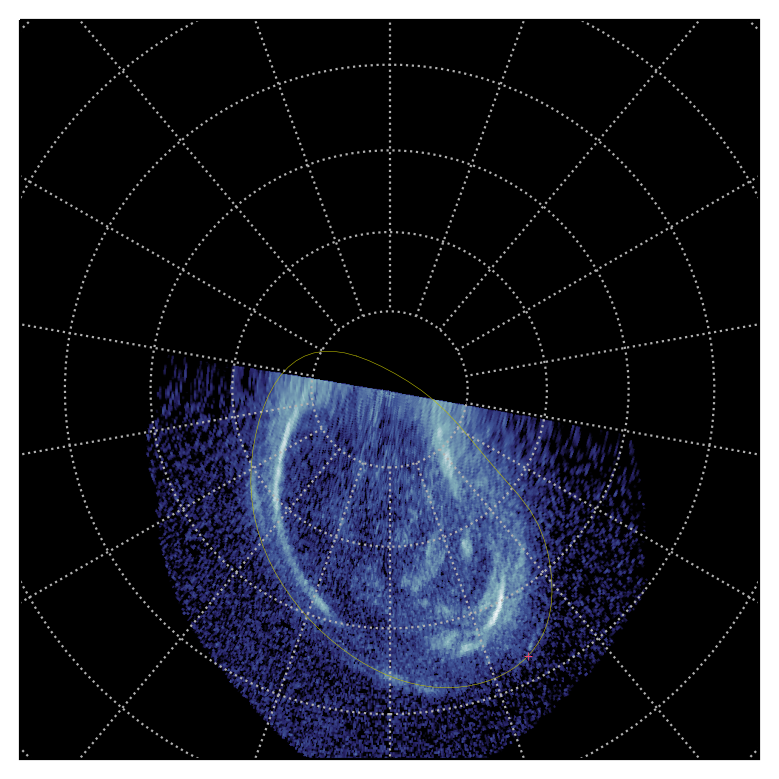

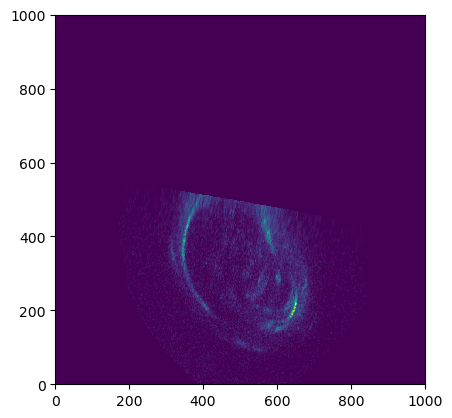

In [12]:
extdeg = 45.0
fig, ax = plt.subplots(dpi=200)
ax, dimage, gl = h.tvPolar(ax, vmin=10, vmax=2000,
                  draw_labels=False, refmainoval=False,
                  satovals=['eu'],
                  reflon=None,
                  # reflon=h.alm.cml,
                  ext=extdeg,
                  )

print(dimage.shape)
Npx = dimage.shape[0]
dimage = dimage[:,::-1]
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')
ax.pcolormesh(dimage)
plt.show()

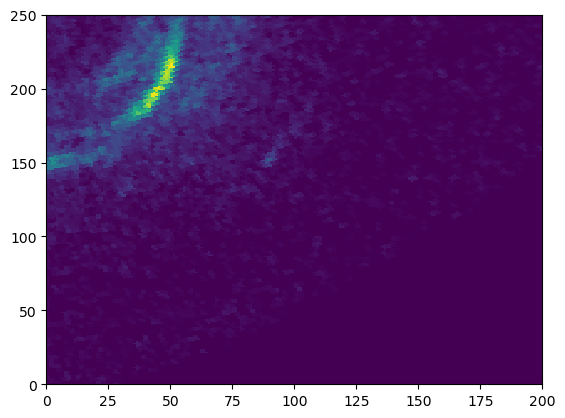

In [13]:
x0, x1 = 600, 800
y0, y1 = 0, 250
img = dimage[y0:y1,x0:x1]
fig, ax = plt.subplots(dpi=100)
ax.pcolormesh(img)
plt.show()

開口測光 (Aperture Photometry)

In [14]:
# Find bright spots
mean = np.average(img)
median = np.median(img)
std = np.std(img)
print('STD', std)
thres = 1.2*std
daofind = DAOStarFinder(fwhm=2.0, threshold=thres)  
# https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html
# DAOStarFinderのfluxの定義 ... stdのfactor倍
sources = daofind(img)  
print(sources)

STD 148.40918
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 29.796068071218386 ...  1.170880675315857  -0.17128159572448953
  2 1.0459864128155354 ...  2.230254650115967   -0.8708861338829428
  3  5.358018557329415 ... 1.3547718524932861   -0.3296654122959749
  4  58.15733014218266 ... 1.2572107315063477  -0.24852019870926192
  5 17.111891734773103 ... 1.3199609518051147  -0.30140270932825436
  6 45.034983958826786 ... 1.1406716108322144  -0.14290158227541522
  7  88.63540305316786 ... 1.4107416868209839   -0.3736187493782147
  8  1.682038078468359 ...  2.455096483230591   -0.9751714105072152
  9  7.486319540363095 ... 1.4581048488616943   -0.4094718854776285
 10  90.93870842474168 ... 1.0224813222885132 -0.024138458688373766
...                ... ...                ...                   ...
 44  39.56293410304895 ... 1.2548091411590576   -0.2464441845727092
 45  72.46565867082855 ... 1.22145

=== JRM33 Estimation ===
Sys3,lat 152.62117521949583 52.78842080905891
Wlong [deg] 152.62117521949583
Lat [deg] 52.78842080905891
extdeg 45.0
ftps3lat 52.78842080905891
=== The spot ===
Nearest [px]: 6 [688.63540305 151.91041197]
Number of pixels [px]:  25
Brightness peak [kR]:  486.1923828125
Brightness flux [kR]:  251.24041979047468
Wlong [deg] 151.54601651574762
Lat [deg] 53.68228541345377
    final_phot   
-----------------
9480.407366072915


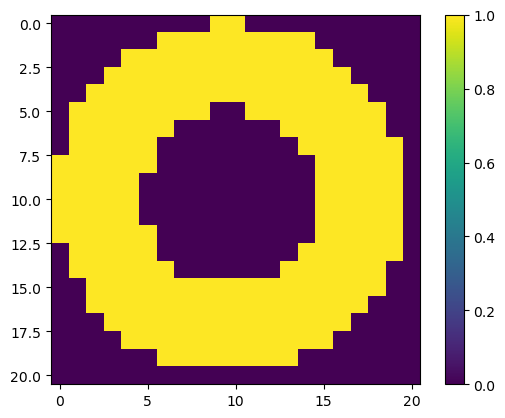

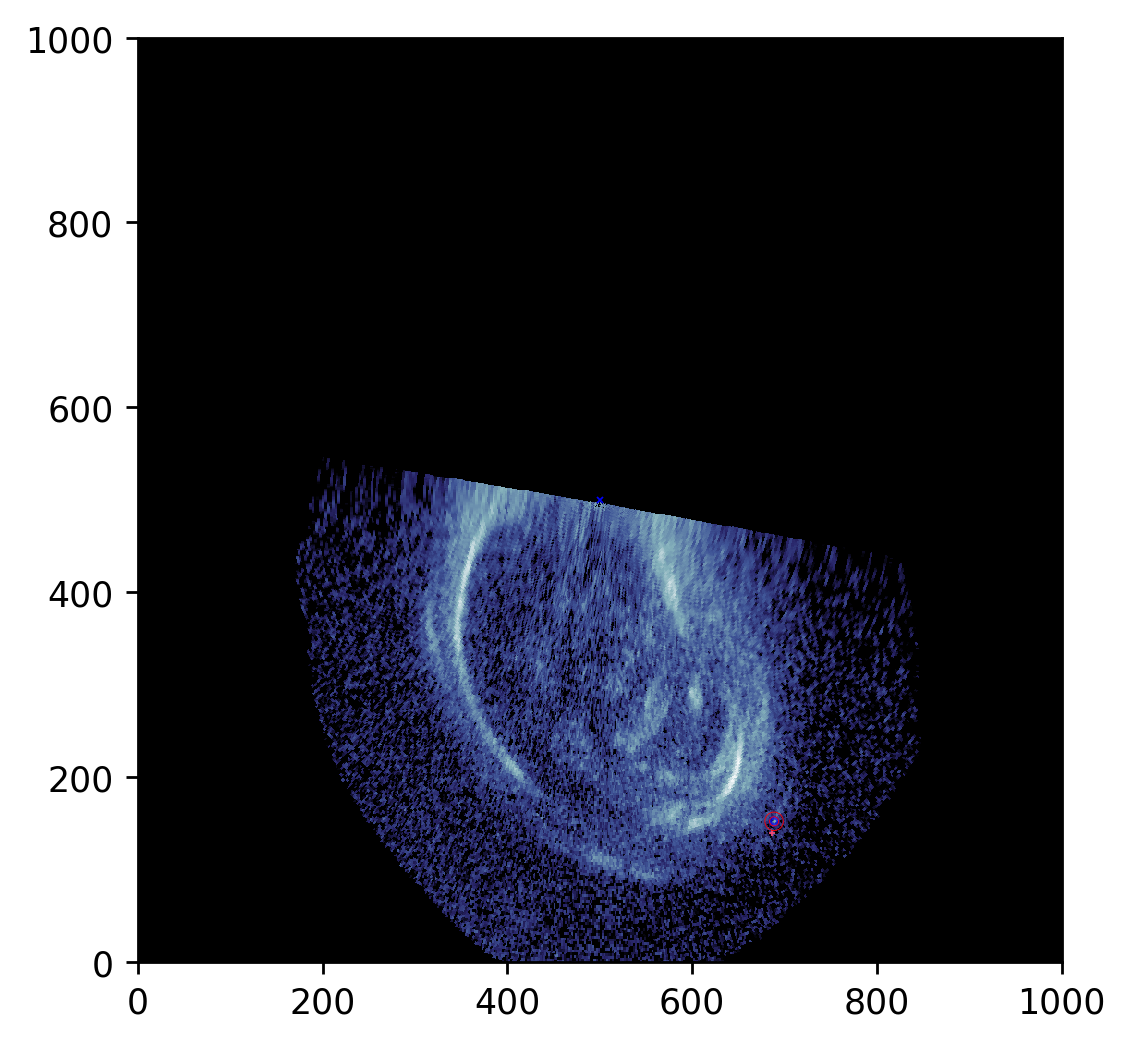

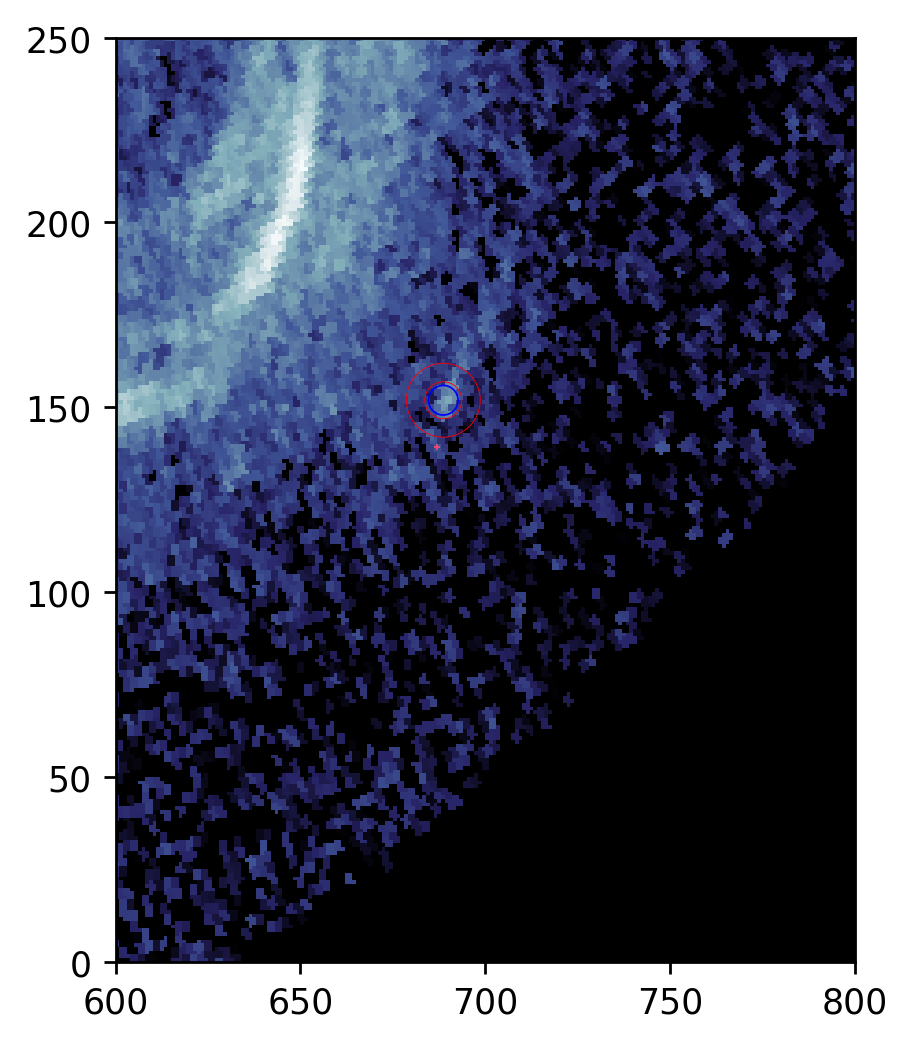

In [24]:
ftps3wlon = h.s3wlon_lin            # [deg]
ftps3lat = h.s3lat_lin              # [deg]
print('=== JRM33 Estimation ===')
print('Sys3,lat', ftps3wlon, ftps3lat)
print('Wlong [deg]', ftps3wlon)
print('Lat [deg]', ftps3lat)

ftpelon = 360-(ftps3wlon-90)        # [deg]
ftpcolat = 90-ftps3lat              # [deg]
ftpR = ftpcolat*(Npx/(2*extdeg))    # [px]
ftpR = (Npx/2)*(math.tan(math.radians(ftpcolat/2))/math.tan(math.radians((90-extdeg)/2)))     # [px]
print('extdeg', extdeg)
print('ftps3lat', ftps3lat)
ftpX = ftpR*np.cos(np.radians(ftpelon))         # [px]
ftpY = ftpR*np.sin(np.radians(ftpelon))         # [px]
ftpX += Npx/2
ftpY += Npx/2
# print(ftpcolat, ftpR, ftpX, ftpY)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  # [px]
positions[:,0] += x0    # [px]
positions[:,1] += y0    # [px]

posarg0 = np.argmin(np.absolute((positions[:,0]-ftpX)**2 + (positions[:,1]-ftpY)**2))
print('=== The spot ===')
print('Nearest [px]:', posarg0, positions[posarg0,:])
print('Number of pixels [px]: ', sources['npix'][posarg0])
print('Brightness peak [kR]: ', sources['peak'][posarg0])
print('Brightness flux [kR]: ', sources['flux'][posarg0]*thres)

posX = positions[posarg0,0]-Npx/2
posY = positions[posarg0,1]-Npx/2
posR = math.sqrt(posX**2 + posY**2)             # [px]
poslat = posR*(2*extdeg/Npx)
poslat = math.degrees(2*math.atan2(posR*math.tan(0.5*math.radians(90-extdeg)), Npx/2))
postheta = math.atan2(posY,posX)-0.5*np.pi
# print('theta [deg]', math.degrees(postheta))
print('Wlong [deg]', -math.degrees(postheta))
print('Lat [deg]', 90-poslat)

# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=5., r_out=10.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
print(rawflux['final_phot'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()




# Plots
fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=1.0, alpha=0.6)
annulus_apertures.plot(color='red', lw=0.25)
plt.show()

fig, ax = plt.subplots(dpi=250)
ax.set_aspect('equal')
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)
# ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(), vmin=median-5*std, vmax=median+5*std, zorder=0.1)
ax.pcolormesh(dimage, cmap=TScmap().MIDNIGHTS(),
              norm=colors.LogNorm(vmin=10, vmax=2000),
              zorder=0.1)
ax.plot(ftpX, ftpY,
        markersize=2, marker='+', markerfacecolor='#f24875',
        markeredgecolor='#f24875', markeredgewidth=0.5, zorder=1)
ax.plot(Npx/2, Npx/2,
        markersize=2, marker='x', markerfacecolor='blue',
        markeredgecolor='blue', markeredgewidth=0.5, zorder=1)
apertures.plot(color='blue', lw=0.5, alpha=1.0)
annulus_apertures.plot(color='red', lw=0.25, alpha=1.0)
plt.show()

 id      xcenter           ycenter      ...     final_phot      final_phot_ave  
           pix               pix        ...                                     
--- ----------------- ----------------- ... ----------------- ------------------
  1 688.6354030531679 151.9104119679861 ... 9480.407366072915 188.60671185441504
   aperture_sum   
------------------
12033.614268562587
  annulus_median  
------------------
50.794437408447266
     aper_bkg    
-----------------
2553.206902489672
  final_phot_ave  
------------------
188.60671185441504


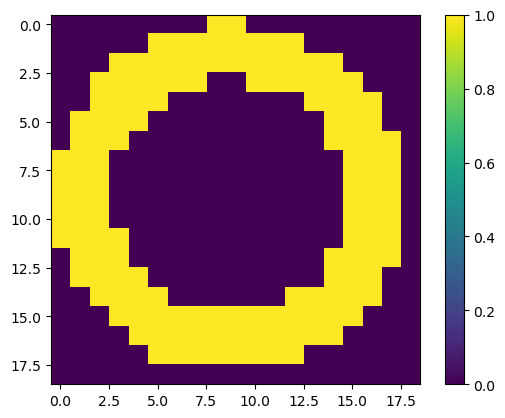

In [25]:
# Aperture photometry
apertures = CircularAperture(positions[posarg0,:], r=4.)
rawflux = aperture_photometry(dimage, apertures)
# print(rawflux)

# 局所的な背景を測定する
# 各スポットを中心とした輪っかを作成
annulus_apertures = CircularAnnulus(positions[posarg0,:], r_in=6., r_out=9.)

# sigmaクリッピング法を用いる
# http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
# ここではガウシアン開口ではなくただの円開口を用いる
# rawfluxには開口内の合計カウント値が入っているので、バックグラウンドとして`bkg_median*apertures.area`
# を作成し、`rawflux['aperture_sum']`からさっ引く。
annulus_masks = annulus_apertures.to_mask(method='center')
annulus_data = annulus_masks.multiply(dimage)
annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出
_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
bkg_median = median_sigclip
rawflux['annulus_median'] = bkg_median
rawflux['aper_bkg'] = bkg_median*apertures.area
rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()

In [28]:
def Aperture(IMAGE, POSITION):
    """_summary_

    Args:
        IMAGE (2d ndarray): raw image
        POSITION (1d array): position of one spot in the raw image

    Returns:
        apertures (CircularAperture): \n
        rawflux (QTable): QTable including the spot position and the final photometry averaged in pixels. \n
            `['id']` \n
            `['xcenter']` : x position [px] \n
            `['ycenter']` : y position [px] \n
            `['aperture_sum']` : summation of brightness in the target aperture
            `['annulus_median']` : the median inside the donut \n
            `['aper_bkg']` : summation of the median inside the donut \n
            `['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']` \n
            `['final_phot_ave'] = rawflux['final_phot']/apertures.area`
            
    """
    # Aperture photometry
    apertures = CircularAperture(POSITION, r=4.)
    rawflux = aperture_photometry(IMAGE, apertures)

    # Make a donut to calculate the local background in.
    annulus_apertures = CircularAnnulus(POSITION, r_in=5.5, r_out=9.)

    # Sigma-clipping
    # http://www.astroarts.com/products/stlimg7/support/faq-general/composite_methods-j.shtml
    annulus_masks = annulus_apertures.to_mask(method='center')

    # Mask inside the donut
    annulus_data = annulus_masks.multiply(IMAGE)
    annulus_data_1d = annulus_data[annulus_masks.data > 0]  # 輪っか内部の値だけ抽出

    # Calculate the median as the local background
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median = median_sigclip*1.0

    # Add results to the rawflux data
    rawflux['annulus_median'] = bkg_median
    rawflux['aper_bkg'] = bkg_median*apertures.area
    rawflux['final_phot'] = rawflux['aperture_sum'] - rawflux['aper_bkg']
    rawflux['final_phot_ave'] = rawflux['final_phot']/apertures.area
    
    return apertures, rawflux


 id      xcenter           ycenter      ...     final_phot      final_phot_ave  
           pix               pix        ...                                     
--- ----------------- ----------------- ... ----------------- ------------------
  1 688.6354030531679 151.9104119679861 ... 9480.407366072915 188.60671185441504
   aperture_sum   
------------------
12033.614268562587
  annulus_median  
------------------
50.794437408447266
     aper_bkg    
-----------------
2553.206902489672
  final_phot_ave  
------------------
188.60671185441504


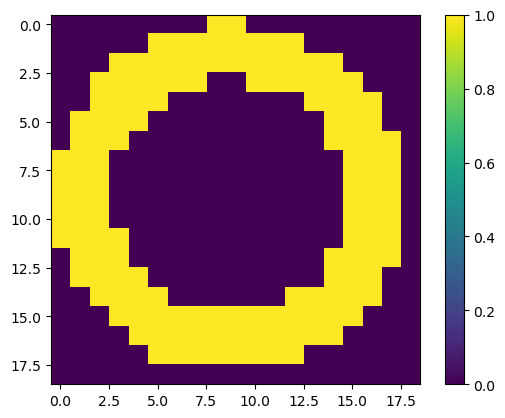

In [29]:
# Aperture photometry
aperture, rawflux = Aperture(dimage, positions[posarg0,:])
print(rawflux)
print(rawflux['aperture_sum'])
print(rawflux['annulus_median'])
print(rawflux['aper_bkg'])
print(rawflux['final_phot_ave'])
plt.imshow(annulus_masks)
plt.colorbar()
plt.show()